# Stochastic Optimization with Heavy-Tailed Noise via Accelerated Gradient Clipping

### 1. Постановка задачи

$$\min_{x \in \mathbb{R}^n}f(x), \quad f(x) = \mathbb{E}_{\xi}[f(x, \xi)],$$
где $f(x)$
  - выпуклая
  - гладкая
  - $\forall x \in \mathbb{R}^n \rightarrow \exists \nabla f(x, \xi): \mathbb{E}_{\xi}[\nabla f(x, \xi)] = \nabla f(x), \quad \mathbb{E}_{\xi}[\|\nabla f(x, \xi) - \nabla f(x)\|^2_2] \leq \sigma^2$


### 2. Идея статьи

Результатом статьи является представление 2 новых алгоритмов - **"Clipped Stochastic Similar Triangles Method (clipped-SSTM)"** и **"SGD with Clippin"**. Суть, которых заключается [TO DO]

### 3. Теоретические результаты

### 4. Суть доказательства

### 5. Эксперименты из статьи

#### 5.1 Сlipped SGD

В этой части мы реализуем алгоритм Сlipped SGD и повторим эксперименты из секции 1.2 (H1 полной статьи).

Рассмотрим функцию $$f(x, \xi) = \frac{\|x\|_2^2}{2} + \langle \xi, x \rangle,$$
где $\xi$ - случайная величина с матожиданием 0 и дисперсией $\sigma^2 = 1$.

Будут изучены 3 распределения.

1. Norm
2. Weibull distribution
3. Burr Type XII distribution

Для всех распределений установим параметры:
 - $\gamma = 0.001$ - размер шага
 - $n = 100$ - размерность x
 - $\lambda = 100$ - уровень клиппинга

In [71]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy
import seaborn as sns
import math

sns.set_theme(style="darkgrid")

In [47]:
def f(x):
    return 0.5 * (norm(x))**2

def grad_f(x, xi):
    return x + xi

def ClippedSGD(f, grad_f, x_0, stepsize, clipping_level,
               number_its, distribution_rvs, **args_distribution):
    """
        f - функция, минимум которой ищем
        grad_f - градиент f
        x_0 - начальная точка
        stepsize - размер шага > 0
        clipping_level > 0
        number_its - количество итераций
        distribution_rvs - генерация величин из какого-то распределения. Ожидаются функции из sps
    """
    info = [f(x_0)]
    for k in range(number_its):
        xi = distribution_rvs(size=len(x_0), **args_distribution)
        grad = grad_f(x_0, xi)
        x_0 = x_0 - stepsize * min(1, clipping_level / norm(grad)) * grad
        info.append(f(x_0))
    return (x_0, info)


def SGD(f, grad_f, x_0, stepsize, number_its,
        distribution_rvs, **args_distribution):
    """
        f - функция, минимум которой ищем
        grad_f - градиент f
        x_0 - начальная точка
        stepsize - размер шага > 0
        number_its - количество итераций
        distribution_rvs - генерация величин из какого-то распределения. Ожидаются функции из sps
    """
    info = [f(x_0)]
    for k in range(number_its):
        xi = distribution_rvs(size=len(x_0), **args_distribution)
        grad = grad_f(x_0, xi)
        x_0 = x_0 - stepsize * grad
        info.append(f(x_0))
    return (x_0, info)


def CreatePlot(info_sgd, info_csgd, title):
    plt.figure(figsize=(10, 6))
    plt.yscale('log')
    plt.plot(np.arange(len(info_sgd)), info_sgd, label="sgd", c='green')
    plt.plot(np.arange(len(info_csgd)), info_csgd, label="csgd", c='red')
    plt.title(title)
    plt.legend()

Для нормального распределения уставновим $a = 0, \sigma = 1$.

In [68]:
x_csgd, info_csgd = ClippedSGD(f, grad_f, 0.01 * np.array(range(100)),
                               0.001, 100, 100000, sps.norm.rvs,
                               loc=0, scale=1)

x_sgd, info_sgd = SGD(f, grad_f, 0.01 * np.array(range(100)),
                      0.001, 100000, sps.norm.rvs,
                      loc=0, scale=1)

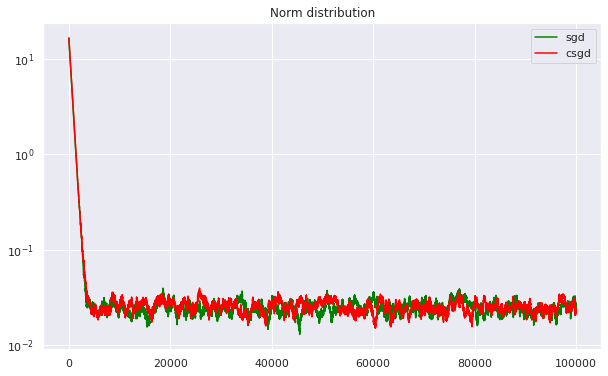

In [72]:
CreatePlot(info_sgd, info_csgd, "Norm distribution")

Пусть теперь $\xi$ ~ $W(c, \alpha)$

$$E\xi = \alpha Г(1 + \frac{1}{c})$$
$$D\xi = \alpha^2 (Г(1 + \frac{2}{c}) - (Г(1 + \frac{2}{c}))^2)$$

Тогда, чтобы распределение обладало нужными свойствами, возьмем
- $с = 0.2$
- $\alpha = \frac{1}{\sqrt{Г(1 + \frac{2}{c}) - (Г(1 + \frac{2}{c}))^2}}$

In [78]:
c = 0.2
scale = 1 / np.sqrt(scipy.special.gamma(1 + 2 / c) - ((scipy.special.gamma(1 + 1 / c))**2))
loc = -scale * scipy.special.gamma( 1 + 1 / c)

In [81]:
x_csgd, info_csgd = ClippedSGD(f, grad_f, 0.01*np.array(range(100)),
                               0.001, 100, 100000, sps.weibull_min.rvs,
                               c=0.2, loc=loc, scale=scale)

x_sgd, info_sgd = SGD(f, grad_f, 0.01*np.array(range(100)),
                               0.001, 100000, sps.weibull_min.rvs,
                               c=0.2, loc=loc, scale=scale)

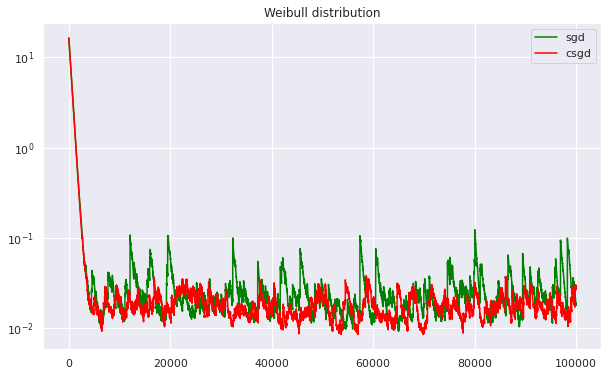

In [82]:
CreatePlot(info_sgd, info_csgd, "Weibull distribution")

Пусть теперь $\xi$ ~ $Burr(c, d)$

$$E\xi^k = d B(\frac{cd - k}{c}, \frac{c + k}{c})$$

Тогда, чтобы распределение обладало нужными свойствами, возьмем
- $с = 1$
- $d = 2.3$

In [75]:
c = 1.0
d = 2.3

first_moment = d * scipy.special.beta((c*d - 1) / c, (c + 1) / c)
second_moment = d * scipy.special.beta((c*d - 2) / c, (c + 2) / c)

scale = 1 / np.sqrt(second_moment - first_moment**2)
loc = -scale * first_moment

x_csgd, info_csgd = ClippedSGD(f, grad_f, 0.01*np.array(range(100)),
                               0.001, 100, 100000, sps.burr12.rvs,
                               c=c, d=d, loc=loc, scale=scale)

x_sgd, info_sgd = SGD(f, grad_f, 0.01*np.array(range(100)),
                               0.001, 100000, sps.burr12.rvs,
                               c=c, d=d, loc=loc, scale=scale)

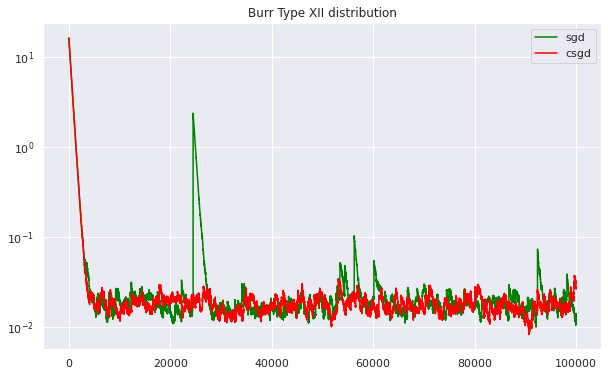

In [76]:
CreatePlot(info_sgd, info_csgd, "Burr Type XII distribution")

**Вывод:**

####  5.2 Clipped Stochastic Similar Triangles Method

### 6. Собсвенные эксперименты

###  Дополнительно

#### Базовая терминология

**Опр.** Пусть дана непрерывно дифференцируемая на $\mathbb{R}^n$ функция $ f(x) : \mathbb{R}^n \longrightarrow \mathbb{R} $ . Будем говорить, что она является **выпуклой**, если для любых x, y $\in \mathbb{R}^n$ выполнено
$$f(y) \geq f(x) + \langle \nabla f(x), y - x \rangle$$

**Опр.** Пусть дана непрерывно дифференцируемая на $\mathbb{R}^n$ функция  $ f(x) : \mathbb{R}^n \longrightarrow \mathbb{R} $. Будем говорить, что данная функция имеет L-Липшицев градиент (говорить, что она является **L-гладкой**), если для любых x, y $\in \mathbb{R}^n$ выполнено

$$\|\nabla f(x) - \nabla f(y)\|_2 \leq L\|x - y\|_2$$

**Опр.** Случайный вектор $\xi$ принадлежит **распределению с легкими хвостами**, если
  1. $\mathbb{E}[\xi]$
  2. $\forall b > 0 \rightarrow \mathbb{P}\{\|\xi - \mathbb{E}[\xi]\|_2 > b\} \leq 2 exp(-\frac{b^2}{2\sigma^2})$ 

Что эквивалентно условию [1]

$$\mathbb{E}[exp(\|\xi - \mathbb{E}[\xi]\|_2^2 / {\sigma^2})] \leq exp(1)$$

#### Ссылки на источники

[0] Stochastic Optimization with Heavy-Tailed Noise via Accelerated Gradient Clipping (Eduard Gorbunov, Marina Danilova, Alexander Gasnikov)

[1] Лемма 2, Chi Jin, Praneeth Netrapalli, Rong Ge, Sham M Kakade, and Michael I Jordan. A short
note on concentration inequalities for random vectors with subgaussian norm. arXiv preprint
arXiv:1902.03736, 2019